In [1]:
# !conda install -c conda-forge imbalanced-learn -y
import gc

import matplotlib.pyplot as plt
import numpy as np




In [2]:
import h5py
import gc

def load_combine_shuffle_data_optimized_hdf5():
    with h5py.File('/gpfs/slac/atlas/fs1/d/hjia625/Smart_Pixel/data.hdf5', 'r') as h5f:
        combined_input = None
        combined_target = None

        for charge_type in ['positive-charge', 'negative-charge']:
            for data_type in ['sig', 'bkg']:
                # Construct dataset names
                input_dataset_name = f'{charge_type}_{data_type}_input'
                target_dataset_name = f'{charge_type}_{data_type}_target'

                # Check if the dataset exists and load data sequentially
                if input_dataset_name in h5f and target_dataset_name in h5f:
                    input_data = h5f[input_dataset_name][:].astype(np.float16)
                    target_data = h5f[target_dataset_name][:].astype(np.float16)

                    if combined_input is None:
                        combined_input = input_data
                        combined_target = target_data
                        # Free memory of the loaded data
                        del input_data, target_data
                        gc.collect()

                    else:
                        combined_input = np.vstack((combined_input, input_data))
                        combined_target = np.vstack((combined_target, target_data))
                        # Free memory of the loaded data
                        del input_data, target_data
                        gc.collect()

                else:
                    print(f"Dataset {input_dataset_name} or {target_dataset_name} not found.")

        # Shuffling
        indices = np.arange(combined_input.shape[0])
        np.random.shuffle(indices)
        combined_input = combined_input[indices]
        combined_target = combined_target[indices]

        return combined_input, combined_target

# Example usage
X, y = load_combine_shuffle_data_optimized_hdf5()

In [3]:
X = X[0:700000]
y = y[0:700000]
X  = X.reshape(-1,8,13,21)
inf_exists = np.isinf(X).any()
print(inf_exists)
n = y.shape[0]
one_hot = np.zeros((n, 3))

# Class 1: np.abs(y[:, 8]) > 2
one_hot[np.abs(y[:, 8]) >= 2, 0] = 1

# Class 2: np.abs(y[:, 8]) <= 2 and y[:, 13] == 1
one_hot[(np.abs(y[:, 8]) < 2) & (y[:, 8] > 0), 1] = 1

# Class 3: np.abs(y[:, 8]) <= 2 and y[:, 13] == -1
one_hot[(np.abs(y[:, 8]) < 2) & (y[:, 8] < 0), 2] = 1

X = X.astype(np.float32)
X_summed = np.sum(X, axis=(1, 3))
inf_exists = np.isinf(X_summed).any()
print(inf_exists)
# Splitting X into three classes based on y
X_class_1 = X_summed[one_hot[:, 0] == 1]
X_class_2 = X_summed[one_hot[:, 1] == 1]
X_class_3 = X_summed[one_hot[:, 2] == 1]

del X_summed, X, y
gc.collect()
number_1 = X_class_1.shape[0]
number_2 = X_class_2.shape[0]
number_3 = X_class_3.shape[0]
# Calculating the average shape for each class



False
False


In [4]:
avg_class_1 = np.sum(X_class_1, axis=0) / number_1
avg_class_2 = np.sum(X_class_2, axis=0) / number_2
avg_class_3 = np.sum(X_class_3, axis=0) / number_3


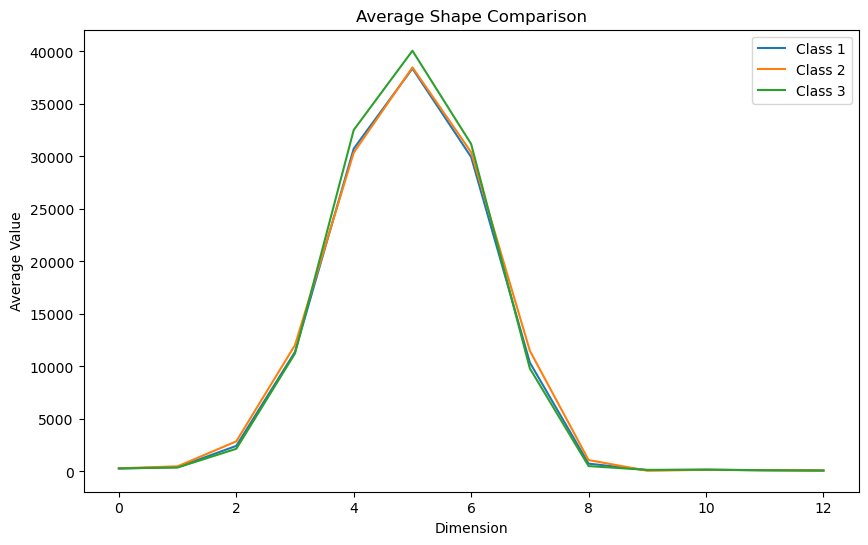

In [5]:
plt.figure(figsize=(10, 6))

# Plotting all average shapes on the same plot for comparison
plt.plot(avg_class_1, label='Class 1')
plt.plot(avg_class_2, label='Class 2')
plt.plot(avg_class_3, label='Class 3')

plt.title('Average Shape Comparison')
plt.xlabel('Dimension')
plt.ylabel('Average Value')
plt.legend()

plt.show()